In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words=open('names.txt','r').read().splitlines()

In [10]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
block_size=3

def build_dataset(words):
  X,Y=[],[]
  for w in words:
    
  
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
     
        context=context[1:] + [ix]
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape)       
  return X,Y
     
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr =build_dataset(words[:n1]) #80%
Xdev,Ydev=build_dataset(words[n1:n2])#10%
Xte,Yte=build_dataset(words[n2:])#10%


torch.Size([182625, 3])
torch.Size([22655, 3])
torch.Size([22866, 3])


In [12]:
def cmp(s,dt,t):
    
    ex =torch.all(dt==t.grad).item()
    app=torch.allclose(dt,t.grad)
    maxdiff=(dt-t.grad).abs().max().item()
    print(f'{s:15s}|exact:{str(ex):5s}|approximate:{str(app):5s}|maxdiff:{maxdiff}')

In [13]:
n_embd=10
n_hidden=64

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),          generator=g)
#一层
W1=torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/((n_embd*block_size)**0.5)
b1=torch.randn(n_hidden,                   generator=g)*0.1
#二层
W2=torch.randn((n_hidden,vocab_size),       generator=g)*0.1
b2=torch.randn(vocab_size,                  generator=g)*0.1
#批量参数
bngain=torch.ones((1,n_hidden))*0.1+1.0
bnbias=torch.zeros((1,n_hidden))*0.1

#bnmean_running=torch.zeros((1,n_hidden))
#bnstd_running=torch.ones((1,n_hidden))
parameters=[C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
     p.requires_grad=True

4137


In [14]:
batch_size=32
n=batch_size
ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
#构建小型
Xb,Yb=Xtr[ix],Ytr[ix]

In [15]:
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1) #把字符嵌入到向量中

#线性变换层一层
    hprebn=embcat@W1+b1 #隐藏层预激活

#标准化层，输入批次数据进行标准化处理
    bnmeani=1/n*hprebn.sum(0,keepdim=True)
    bndiff=hprebn-bnmeani
    bndiff2=bndiff**2
    bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True)
    bnvar_inv=(bnvar+1e-5)**-0.5
    bnraw=bndiff*bnvar_inv
    hpreact=bngain*bnraw+bnbias

#非线性
    h=torch.tanh(hpreact)
#线性变换二层
    logits=h@W2+b2
#最交叉熵损失
    logit_maxes=logits.max(1,keepdim=True).values
    norm_logits=logits -logit_maxes
    counts=norm_logits.exp()
    counts_sum=counts.sum(1,keepdim=True)
    counts_sum_inv=counts_sum**-1
    probs=counts*counts_sum_inv
    logprobs=probs.log()
    loss=-logprobs[range(n),Yb].mean()

    for p in parameters:
       p.grad = None
    for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
              bnvar_inv,norm_logits,logit_maxes,logits,h,hpreact,
              bnraw,bnvar,bndiff2,bndiff,hprebn,bnmeani,
              embcat,emb]:
        t.retain_grad()
        
    loss.backward()
    loss

tensor(3.3482, grad_fn=<NegBackward0>)

In [16]:
#向前传递
dlogprobs=torch.zeros_like(logprobs)
dlogprobs[range(n),Yb]=-1.0/n
dprobs=(1.0/probs)*dlogprobs
dcounts_sum_inv=(counts*dprobs).sum(1,keepdim=True)
dcounts=counts_sum_inv*dprobs
dcounts_sum=(-counts_sum**-2)*dcounts_sum_inv
dcounts+=torch.ones_like(counts)*dcounts_sum
dnorm_logits=counts*dcounts
dlogits=dnorm_logits.clone()
dlogit_maxes=(-dnorm_logits).sum(1,keepdim=True)
dlogits+=F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])*dlogit_maxes
dh=dlogits@W2.T
dW2=h.T@dlogits
db2=dlogits.sum(0)
dhpreact=(1.0-h**2)*dh
dbngain=(bnraw*dhpreact).sum(0,keepdim=True)
dbnraw=bngain*dhpreact
dbnbias=dhpreact.sum(0,keepdim=True)
dbndiff=bnvar_inv*dbnraw
dbnvar_inv=(bndiff*dbnraw).sum(0,keepdim=True)
dbnvar=(-0.5*(bnvar+1e-5)**-1.5)*dbnvar_inv
dbndiff2=(1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar
dbndiff+=(2*bndiff)*dbndiff2
dhprebn=dbndiff.clone()
dbnmeani=(-dbndiff).sum(0)
dhprebn+=1.0/n*(torch.ones_like(hprebn)*dbnmeani)
dembcat=dhprebn@W1.T
dW1=embcat.T@dhprebn
db1=dhprebn.sum(0)
demb=dembcat.view(emb.shape)
dC=torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]

cmp('logprobs',dlogprobs,logprobs)
cmp('probs',dprobs,probs)
cmp('counts_sum_inv',dcounts_sum_inv,counts_sum_inv)
cmp('counts_sum',dcounts_sum,counts_sum)
cmp('counts',dcounts,counts)
cmp('norm_logits',dnorm_logits,norm_logits)
cmp('logit_maxes',dlogit_maxes,logit_maxes)
cmp('logits',dlogits,logits)
cmp('h',dh,h)
cmp('b2',db2,b2)
cmp('hpreact',dhpreact,hpreact)
cmp('bngain',dbngain,bngain)
cmp('bnbias',dbnbias,bnbias)
cmp('bnraw',dbnraw,bnraw)
cmp('bndiff',dbndiff,bndiff)
cmp('bnvar_inv',dbnvar_inv,bnvar_inv)
cmp('bnvar',dbnvar,bnvar)
cmp('bndiff2',dbndiff2,bndiff2)
cmp('bndiff',dbndiff,bndiff)
cmp('bnmeani',dbnmeani,bnmeani)
cmp('hprebn',dhprebn,hprebn)
cmp('embcat',dembcat,embcat)
cmp('W1',dW1,W1)
cmp('b1',db1,b1)
cmp('emb',demb,emb)
cmp('C',dC,C)



logprobs       |exact:True |approximate:True |maxdiff:0.0
probs          |exact:True |approximate:True |maxdiff:0.0
counts_sum_inv |exact:True |approximate:True |maxdiff:0.0
counts_sum     |exact:True |approximate:True |maxdiff:0.0
counts         |exact:True |approximate:True |maxdiff:0.0
norm_logits    |exact:True |approximate:True |maxdiff:0.0
logit_maxes    |exact:True |approximate:True |maxdiff:0.0
logits         |exact:True |approximate:True |maxdiff:0.0
h              |exact:True |approximate:True |maxdiff:0.0
b2             |exact:True |approximate:True |maxdiff:0.0
hpreact        |exact:True |approximate:True |maxdiff:0.0
bngain         |exact:True |approximate:True |maxdiff:0.0
bnbias         |exact:True |approximate:True |maxdiff:0.0
bnraw          |exact:True |approximate:True |maxdiff:0.0
bndiff         |exact:True |approximate:True |maxdiff:0.0
bnvar_inv      |exact:True |approximate:True |maxdiff:0.0
bnvar          |exact:True |approximate:True |maxdiff:0.0
bndiff2       

In [17]:
dlogits[0]*n

tensor([ 0.0731,  0.0872,  0.0182,  0.0518,  0.0192,  0.0845,  0.0231,  0.0355,
        -0.9827,  0.0319,  0.0364,  0.0370,  0.0371,  0.0285,  0.0345,  0.0132,
         0.0085,  0.0190,  0.0148,  0.0545,  0.0513,  0.0209,  0.0247,  0.0721,
         0.0584,  0.0259,  0.0215], grad_fn=<MulBackward0>)

In [18]:
dlogits[0].sum()

tensor(4.6566e-10, grad_fn=<SumBackward0>)

In [19]:
F.softmax(logits,1)[0]

tensor([0.0731, 0.0872, 0.0182, 0.0518, 0.0192, 0.0845, 0.0231, 0.0355, 0.0173,
        0.0319, 0.0364, 0.0370, 0.0371, 0.0285, 0.0345, 0.0132, 0.0085, 0.0190,
        0.0148, 0.0545, 0.0513, 0.0209, 0.0247, 0.0721, 0.0584, 0.0259, 0.0215],
       grad_fn=<SelectBackward0>)

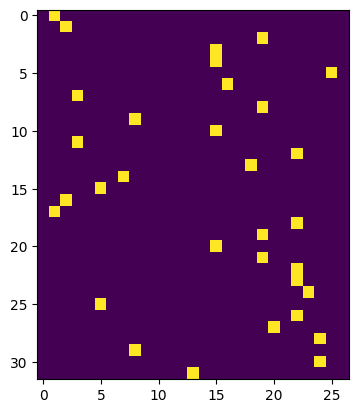

In [20]:
plt.imshow(F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]))

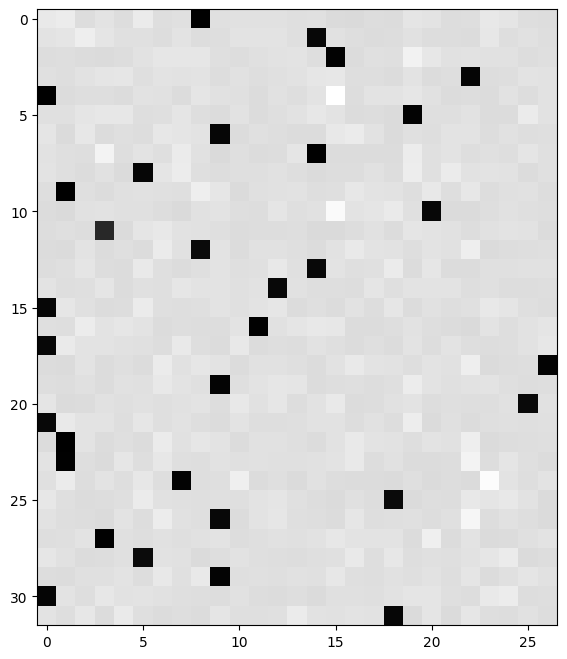

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(),cmap='gray')
           

In [22]:
loss_fast=F.cross_entropy(logits,Yb)
print(loss_fast.item(),'diff',(loss_fast-loss).item())

3.348198175430298 diff 0.0


In [23]:
#向后传导
dlogits=F.softmax(logits,1)
dlogits[range(n),Yb]-=1
dlogits/=n
cmp('logits',dlogits,logits)

logits         |exact:False|approximate:True |maxdiff:1.0477378964424133e-08


In [24]:
hpreact_fast=bngain*(hprebn-hprebn.mean(0,keepdim=True))/torch.sqrt(hprebn.var(0,keepdim=True,unbiased=True))
print('max diff:',(hpreact_fast -hpreact).abs().max())

max diff: tensor(3.6001e-05, grad_fn=<MaxBackward1>)


In [25]:
n_embd=10
n_hidden=200

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),          generator=g)
#一层
W1=torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/((n_embd*block_size)**0.5)
b1=torch.randn(n_hidden,                   generator=g)*0.1
#二层
W2=torch.randn((n_hidden,vocab_size),       generator=g)*0.1
b2=torch.randn(vocab_size,                  generator=g)*0.1
#批量参数
bngain=torch.ones((1,n_hidden))*0.1+1.0
bnbias=torch.zeros((1,n_hidden))*0.1

#bnmean_running=torch.zeros((1,n_hidden))
#bnstd_running=torch.ones((1,n_hidden))
parameters=[C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
     p.requires_grad=True

max_steps=200000
batch_size=32
n=batch_size
lossi=[]

for i in range(max_steps):
    
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
#构建小型
    Xb,Yb=Xtr[ix],Ytr[ix]
    
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1) #把字符嵌入到向量中

#线性变换层一层
    hprebn=embcat@W1+b1 #隐藏层预激活

#标准化层，输入批次数据进行标准化处理
    bnmeani=1/n*hprebn.sum(0,keepdim=True)
    bndiff=hprebn-bnmeani
    bndiff2=bndiff**2
    bnvar=1/(n-1)*(bndiff2).sum(0,keepdim=True)
    bnvar_inv=(bnvar+1e-5)**-0.5
    bnraw=bndiff*bnvar_inv
    hpreact=bngain*bnraw+bnbias

#非线性
    h=torch.tanh(hpreact)

    logits=h@W2+b2
    loss=F.cross_entropy(logits,Yb)
#最交叉熵损失
    #logit_maxes=logits.max(1,keepdim=True).values
    #norm_logits=logits -logit_maxes
    #counts=norm_logits.exp()
    #counts_sum=counts.sum(1,keepdim=True)
    #counts_sum_inv=counts_sum**-1
    #probs=counts*counts_sum_inv
    #logprobs=probs.log()
    #loss=-logprobs[range(n),Yb].mean()

    for p in parameters:
       p.grad = None
    loss.backward()
#手动反向传播
    dlogits=F.softmax(logits,1)
    dlogits[range(n),Yb]-=1
    dlogits/=n
#第二层反向传播   
    dh=dlogits@W2.T
    dW2=h.T@dlogits
    db2=dlogits.sum(0)
    #tanh
    dhpreact=(1.0-h**2)*dh
    #批量反向传播
    dbngain=(bnraw*dhpreact).sum(0,keepdim=True)
    dbnraw=bngain*dhpreact
    dbnbias=dhpreact.sum(0,keepdim=True)
    dhprebn=bngain*bnvar_inv/n*(n*dhpreact-dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    #第一层
    dembcat=dhprebn@W1.T
    dW1=embcat.T@dhprebn
    db1=dhprebn.sum(0)
    demb=dembcat.view(emb.shape)
    dC=torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]
   # dC,dW1,dW2,db2,dbngain,dbnbias=None,None,None,None,None,None
    grads=[dC,dW1,db1,dW2,db2,dbngain,dbnbias]

    lr=0.1 if i<100000 else 0.01
    for p , grad in zip(parameters,grads):
        p.data+=-lr*p.grad

    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())

    if i>=100:
        break
    


12297
      0/ 200000:3.827937


In [26]:
for p,g in zip(parameters,grads):
    cmp(str(tuple(p.shape)),g,p)

(27, 10)       |exact:False|approximate:True |maxdiff:1.4901161193847656e-08
(30, 200)      |exact:False|approximate:True |maxdiff:1.1175870895385742e-08
(200,)         |exact:False|approximate:True |maxdiff:6.868503987789154e-09
(200, 27)      |exact:False|approximate:True |maxdiff:1.4901161193847656e-08
(27,)          |exact:False|approximate:True |maxdiff:7.450580596923828e-09
(1, 200)       |exact:False|approximate:True |maxdiff:2.3283064365386963e-09
(1, 200)       |exact:False|approximate:True |maxdiff:4.6566128730773926e-09


In [27]:
with torch.no_grad():
    emb=C[Xtr]
    embcat=emb.view(emb.shape[0],-1) #把字符嵌入到向量中

    #线性变换层一层
    hpreact=embcat@W1+b1 #隐藏层预激活
    bnmean=hpreact.mean(0,keepdim=True)
    bnvar=hpreact.var(0,keepdim=True,unbiased=True)

In [28]:
@torch.no_grad()
def split_loss(split):
  x,y ={
    'train':(Xtr,Ytr),
    'val':(Xdev,Ydev),
    'test':(Xte,Yte),
}[split]
  emb =C[x]
  embcat=emb.view(emb.shape[0],-1)
  h= torch.tanh(embcat @W1+b1)
  logits=h@W2+b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.8843586444854736
val 2.886294364929199


In [29]:
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20):

    out=[]
    context = [0]*block_size
    while True:
        
      emb =C[torch.tensor([context])]
      embcat=emb.view(emb.shape[0],-1)
      hpreact=embcat@W1+b1
      hpreact=bngain*(hpreact-bnmean)*(bnvar+1e-5)**-0.5+bnbias
      h=torch.tanh(hpreact)
      logits =h@W2+b2
      probs=F.softmax(logits,dim=1)
      ix = torch.multinomial(probs,num_samples=1,generator=g).item()
      context=context[1:]+[ix]
      out.append(ix)

      if ix ==0:
        break
    print(''.join(itos[i] for i in out))  

eria.
kmyaz.
hzelvndhlial.
qefmrngejgrneg.
azejedie.
iulemi.
jea.
ekein.
qoanarieltzi.
hvqep.
b.
shdbn.
gxhgries.
kkkjrwellqhxntpocfnubz.
gvda.
kyadul.
ehs.
kayja.
shlyan.
hjan.
